# Spark with an Application in KMeans

## Introduction

Companies need to find alternative methods of storing and processing the large amount of data their information systems are producing. This necessitates data scientists to build processing pipelines that distribute the work across a cluster of computers to keep up with the pace of business.     

This tutorial is designed to expose you to the basics of Apache Spark - a distributed computing platform used to analyze and process data. After completing it, you will know some of the most common Spark operations and know how to execute the K-Means clustering algorithm on large, distributed datasets. In particular, upon the completion, you should be able to:
+ [Recognize when to use clustering](#A-Brief-Introduction-to-Clustering-and-the-K-Means-Algorithm)
+ [Explain the K-Means clustering algorithm](#A-Brief-Introduction-to-Clustering-and-the-K-Means-Algorithm)
+ [Set up Apache Spark on your local machine](#Apache-Spark)
+ [Use Spark to process data at scale](#Data-Processing-in-Spark)
+ [Use Spark's machine learing library, MLLib, to execute the K-Means clustering algorithm](#Spark-K-Means-Implementation)

## A Brief Introduction to Clustering and the K-Means Algorithm

Clustering is an "unsupervised" learning task that aims to identify *K* number of subsets in *unlabled* data based on the simlarity of their input features. Samples residing in the same subset after the algorithm has run should be more similar to each other than to the data in other subsets (as measured by a distance metric such as euclidian distance). Here are scenarios where clustering can be used to solve a business problem: 
- How many market segments do we actually have in our current customer base?
- Where can a restaurant chain place two new franchises in a city as to minimize the distance to the majority of their target market?

Popular applications of clustering results include:
- Gain a better understanding of your dataset by looking at groups of similar data points.
- Build a classifier in order to predict to which cluster a new data point is most similar.

Different categories of clustering algorithms apply different methods to discover similar subsets of data. Three examples include:
- [Hierarchial Clustering](http://www.sthda.com/english/wiki/hierarchical-clustering-essentials-unsupervised-machine-learning#algorithm)
 - Agglomerative (bottom-up)
 - Divisive (top-down)
- Instance-Based (Centroid-Model) Clustering
 - K-Means

It can be difficult to define how many clusters you should use for grouping your unlabled dataset. While one may be able to use intuition, many empirical methods for choosing the correct number of clusters exist. While this analysis is outside the scope of this tutorial, you may [read about them here](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set). 

To begin the K-Means algorithm, we must initialize the location of the *K* centers in the data space. Many initialization methods exist; but for simplicity, we will assume that the centers are randomly initialized (placed) in the data space (see [K-Means initialization article](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf) for more information). The K-Means algorithm is as follows:
1. Randomly place *K* cluster centers on the data space.
2. Calculate the distance from every point to all cluster centers.
3. Assign each point to the closest cluster center.
4. Place the *K* cluster centers in the middle of all points assigned to the cluster. 
5. Repeat steps 2-4 until there are no changes in the cluster center to which the point is assigned.

This [helpful visualization by Stanford](http://stanford.edu/class/ee103/visualizations/kmeans/kmeans.html) can give us a more concrete picture of what's going on. After setting up the visualization, repeatedly click the "Find Closest Centroid" and "Update Centroid" until the cluster centers stabliize. 

## IOT Location Dataset 
Throughout this tutorial we'll analyze a small sample of summarized fine-grain movement data gathered from WIFI routers. The original dataset consists of over 35GB of movement location information for ~5,000 users for each second. Our dataset is includes activity from 100 random users summarized to the minute level of detail. Here is a quick look and explanation:

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn # or alternatively plt.style.use('ggplot') for a similar look

matplotlib.rc("figure", figsize=(8,6))
matplotlib.rc("axes", labelsize=16, titlesize=16)
matplotlib.rc("xtick", labelsize=14)
matplotlib.rc("ytick", labelsize=14)
matplotlib.rc("legend", fontsize=14)
matplotlib.rc("font", size=14)

In [2]:
mvmt_col_heading = ['user','location_code','month','day','year','hour','minute','visited_seconds','adjacent_seconds']
mvmt_df = pd.read_table("OneMinMovementSample.txt", sep="\t", names=mvmt_col_heading)

mvmt_df['visited_seconds'] = mvmt_df['visited_seconds'].astype(int)

mvmt_df.iloc[0:10,]

,user,location_code,month,day,year,hour,minute,visited_seconds,adjacent_seconds
0,3205,1050300107,9,28,2015,8,22,1236,242905
1,3205,1050300098,9,28,2015,8,43,414,1650
2,3205,1050300050,9,28,2015,8,49,104,518
3,3205,1050300097,9,28,2015,8,51,597,701
4,3205,1050300050,9,28,2015,9,1,183,780
5,3205,1050300098,9,28,2015,9,4,3126,3309
6,3205,1050300049,9,28,2015,9,56,334,3460
7,3205,1050300048,9,28,2015,10,2,370,704
8,3205,1050100027,9,28,2015,10,8,928,1298
9,3205,1030110070,9,28,2015,10,24,3379,4307


The columns can be interpreted as follows: 
- user: A unique ID for each user. 
- location_code: The 10-digit codified location code where the user was seen. 
- month/day/year/hour/minute: The month/day/year/hour/minute the person arrived to location `location_code`,
- visited_seconds: The duration in seconds between the time the user was observed at his or her current location and when he or she was observed at another location.  
- adjacent_seconds: The duration in seconds the user spent at her or her current and previous location. 


## Apache Spark

Apache Spark is a distributed computing platform that can be used for a variety of data analysis and computing tasks. Unlike other distributed computing platforms such as Hadoop, Spark runs all computations in memory across nodes in the cluster - allowing organizations to more quickly derive insights from massive data sets. Engineers and scientists can build analysis pipelines with real-time or historical data. Spark allows many users to simultaneously execute computations on a common dataset. For example, data scientists many train machine learning algorithms while developers issue exploratory, ad-hoc queries. It is through this diverse "stack" of functionality, organizations can provide value to a variety of data consumers. 

### Prerequisites
Spark is written in Scala and needs to run in a JVM; therefore, you will need a Java 6 (or newer) installation. 
You will also need Python version 2.6 (or higher) (**Spark does not work with Python 3**)

### Setting up Spark Locally
You do not need Hadoop to work with Spark locally; if have Hadoop installed, download a version of Spark that has been precompiled for your Hadoop version. I did not have Hadoop installed locally and have downloaded Spark version 1.6.0 built for Hadoop 2.3. Throughout this tutorial, I will assume you have installed Spark version 1.6.0 - Python code in the tutorial may not be compatible with other versions.

Download the pre-compiled Spark version 1.6.0 from: http://spark.apache.org/downloads.html and choose:
+ Spark Release: "1.6.0 (Jan 04 2016)" 
+ Package type: "Pre-built for Hadoop X.Y" (where X.Y is the Hadoop version of your choice [I've chosen 2.3])
+ Download Type: "Direct Download"


Click .tgz link next to bullet number 4: "Download Spark" to download your chosen Spark distribution.


**If you're a Windows user, be sure to install (unpack) Spark to a directory without spaces - you could run into problems otherwise.** (I am running Windows 10 and Spark is installed to the directory: C:\spark-1.6.0-hadoop2.3)

After the download has completed, [untar the download package](https://kb.iu.edu/d/acfi) into the local directory of your choosing. I used 7-zip to untar the package into the directory C:\spark-1.6.0-hadoop2.3. 

Now that you have installed Spark, you're ready to configure the environment variables required by the pyspark interactive shell.

#### Configure Environment Variables

Next set up two environment variables to tell pyspark which Python executable to use. I downloaded Python with Anaconda and set the two variables to:

### Start the Interactive Shell

`cd` into the directory to the directory you extracted the spark distribution to and execute the _pyspark_ command (I've extracted Spark to directory:C:\spark-1.6.0-hadoop2.3: `cd C:\spark-1.6.0-hadoop2.3`):

The command should result in:

#### Relevance of the Shell

The Spark shell gives you the power to perform ad-hoc analysis with distributed datasets in memory across multiple machines (nodes) in a cluster. While this tutorial focuses on operating on datasets in local memory, all concepts introduced are applicable in a distributed envioronment.  

#### Shutting Down the Shell
Once you have confirmed Spark is launching properly, you can stop the interactive shell with the command (we will do all work from this Jupyter Notebook): 

    $ quit()

After you've launched the Spark shell, assign the `spark_path` variable below to the full path of the location where you've extracted Spark:

In [3]:
# assign the spark_path variable to a string with a value of your installation path
# my installation directory is:C:\spark-1.6.0-hadoop2.3
spark_path = "C:\spark-1.6.0-hadoop2.3"

In [4]:
######################################################################################
##################### DO NOT MODIFY THE CONTENTS OF THIS CELL ########################
######################################################################################

#the easiest way to use pyspark with Jupyter notebooks is to use the following code to add 
#the locations of the spark libraries to the list of paths the python interpreter uses to search for python modules 
os.environ['SPARK_HOME'] = spark_path
os.environ['HADOOP_HOME'] = spark_path

#make the python interpreter aware of the location of numerous spark library directories.
sys.path.append(spark_path + "/bin")
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/pyspark/")
sys.path.append(spark_path + "/python/lib")
sys.path.append(spark_path + "/python/lib/pyspark.zip")
sys.path.append(spark_path + "/python/lib/py4j-0.9-src.zip")

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.mllib.clustering import KMeans, KMeansModel

### SparkContext
The `SparkContext` object resides in your main (driver) program and connects to a cluster resource manager (Yarn, Mesos etc.), a program responsible for allocating processes to cluster nodes to complete the Spark job. `SparkContext` is configured with a `SparkConf` object, whose arguments dictate how our Spark job gets executed and the resources (memory, cpu, and worker nodes) allocated our job. The driver program houses the main application and SparkContext and instructs executing nodes which tasks to run. [More information about the architecture of a Spark job can be found in the Spark documentation](http://spark.apache.org/docs/1.6.0/cluster-overview.html).

In [5]:
#parameters you can adjust

#number of cores we will use to compute operations ("*" == all logical cores on machine) on and the amount of 
#memory Spark will allocate to the executors (local pc in our case)
num_cores_used = "*"
spark_executor_memory = "2g"

In [6]:
#set up a spark configuration object. 
conf = SparkConf()
conf.setMaster("local[{0}]".format(num_cores_used))
conf.setAppName("pdsTutorial")

#helps allieviate the 'Python worker could not connect back in time error' 
#that intermittantly occurs when executing spark on your local pc
#http://stackoverflow.com/questions/31225412/sparkexception-python-worker-did-not-connect-back-in-time
conf.set("spark.executor.heartbeatInterval", "3600s")

conf.set("spark.executor.memory", spark_executor_memory)

#set up a new spark context for our application with our desired settings
sc = SparkContext(conf = conf)     

print sc

### Data Processing in Spark

Let's start learning how to code with the Spark API. The Resilient Distributed Dataset (RDD) is Spark's main programming abstraction. They are immutable collections of elements of any Python datatype that Spark partitions across the computing cluster. Operations performed on them are executed simultaneously in memory of all nodes on the cluster. A large number of Spark operations either create an RDD, transform an existing RDD into a new one or return a summary statistic as a result of an operation over an RDD. RDD's can be created by loading data from a variety of sources (such as a local or HDFS file or hive table) so let's put them to work!

### Creating RDDs
RDDs can be created in order to distribute the contents of a text file around the cluster for computation:

In [7]:
#utility function we will use later to print out a sample of the RDD to visualize in tab delimited format
#usage: print_rdd_sample(my_rdd.take(5))
#.take(n) returns an array with the first n elements of the distributed dataset
def print_rdd_sample(rdd_sample_as_list):
    for i in rdd_sample_as_list:
        print i

In [8]:
#create an RDD from a text file 
#RDDs can be created from numerous data sources: in memory list (see example below, a file stored on HDFS , a Hive table)
f = "OneMinMovementSample.txt"
mvmt_rdd = sc.textFile(f)

#Data read from text files create an RDD of strings, we must convert one input string per line read
#into a list of integers to compute summary statistics
parsed_mvmt_data = mvmt_rdd.map(lambda line: [int(float(x)) for x in line.split('\t')] )

The `.parallelize()` method can be used to create an RDD from a python collection within your driver program. This can be used for basic testing in a python interactive shell (Note: contents of RDD created with `sc.parallelize()` must fit into memory on your driver program and should not be used for large data sets). 

In [10]:
#create a list from the federalist papers as an example
#sc.parallelize() can be used for creating RDDs from python lists. 
#load the entire corpus with the code given at the start of assignment 3
import tutorial_support_module
papers, _1, _2 = tutorial_support_module.load_federalist_corpus("FederalistPapers.txt")

print "Papers were loaded as:"
print type(papers)

#create an RDD from a python list
papersRDD = sc.parallelize(papers)


print "\n{0} Papers are now loaded into the driver's memory as:".format(papersRDD.count())
print type(papersRDD)

print "\nEach element of the papersRDD is of type:"
print type(papersRDD.first())

Papers were loaded as:
<type 'list'>

86 Papers are now loaded into the driver's memory as:
<class 'pyspark.rdd.RDD'>

Each element of the papersRDD is of type:
<type 'str'>


In [12]:
#If you're interested, you can view the contents of the first paper with the command below.
#It's omitted here to save space.  

#print papersRDD.first()

### Spark Operations - Actions & Transformations

Before performing many operations on a single RDD, it is often good practice to cache a small subset in memory (we'll cache our entire RDD in memory since its so small):

In [13]:
#cache RDD in memory for faster operations later
parsed_mvmt_data.persist()

PythonRDD[7] at RDD at PythonRDD.scala:43

Now that we have an RDD in memory, let's explore the operations that can be applied and chained together to conduct our analysis. In order to understand the data and its format, we can quickly get the number of elements in our RDD:

In [14]:
print parsed_mvmt_data.count()

10241


as well as its content and datatype:

In [15]:
print type(parsed_mvmt_data.first())
print parsed_mvmt_data.first()

<type 'list'>
[3205, 1050300107, 9, 28, 2015, 8, 22, 1236, 242905]


The previous two functions, `count()` and `first()` are known as actions. These functions (along with `take()` in the code block below) return a result to the driver program based on the contents of an RDD (our driver program resides on our local pc). We can also create new RDDs by applying transformations (such as `filter()` and `union()`) to existing RDDs. The below example show how to apply a function to each element of an RDD to filter our dataset.

In [16]:
#local utility function to be applied to each element of RDD
def isMonth(data_month, month_num):
    return data_month == month_num


#get all the users that arrived to a location in aug after the school year started (assuming the school year starts on August 1)
#filter works as you may expect. It returns a new RDD with all matching rows from the first RDD. 
#Below, we're placing all rows from parsed_mvmt_data where month == 8 into aug_arrivals
aug_arrivals = parsed_mvmt_data.filter(lambda row: row[2] == 8)
sept_arrivals = parsed_mvmt_data.filter(lambda row: isMonth(row[2], 9))

#send a small sample of data back to the driver program (output can also be written to a common file system such as HDFS)
print "Sample of August arrivals:"
print_rdd_sample(aug_arrivals.take(5))

print "\n\nSample of September arrivals:"
print_rdd_sample(sept_arrivals.take(5))
    
#union appends the two datasets together.
#other set operations such as: intersection() exist as well
first_two_months = aug_arrivals.union(sept_arrivals)    

aug_count = aug_arrivals.count()
sept_count = sept_arrivals.count()
union_count = first_two_months.count()

print "\n\n{0} users seen in August".format(aug_count)
print "\n{0} users seen in September".format(sept_count)
print "\n{0} users seen in August and September".format(union_count)


Sample of August arrivals:
[1838, 1020100037, 8, 13, 2015, 8, 48, 10371, -1]
[1838, 1020200023, 8, 13, 2015, 11, 41, 587, 10958]
[1838, 1020200032, 8, 13, 2015, 11, 50, 118141, 118728]
[1656, 1020200021, 8, 13, 2015, 9, 48, 104, -1]
[1656, 1020200023, 8, 13, 2015, 9, 49, 636, 740]


Sample of September arrivals:
[3205, 1050300107, 9, 28, 2015, 8, 22, 1236, 242905]
[3205, 1050300098, 9, 28, 2015, 8, 43, 414, 1650]
[3205, 1050300050, 9, 28, 2015, 8, 49, 104, 518]
[3205, 1050300097, 9, 28, 2015, 8, 51, 597, 701]
[3205, 1050300050, 9, 28, 2015, 9, 1, 183, 780]


1087 users seen in August

3352 users seen in September

4439 users seen in August and September


Two common operations used to process data in Spark are `map()` and `reduce()`. `map()` applies a function to each element of an RDD and receives an the entire element as an input argument. `reduce()` returns the result of an aggregation function of all elements in the RDD to the driver program and is passed the cumulative sum and the current element to be added as arguments (thus the difference between the two annoymous function signatures). These are best illustrated with a couple examples:

In [17]:
#a = cumulative sum
#b = current element to be added
#NOTE: addition is a communitive and associative mathematical operation
#r[7] is the number of seconds visited a user visited a location
all_durations = parsed_mvmt_data.map(lambda r: r[7])
total_duration = all_durations.reduce(lambda a,b: a+b)
print total_duration

41901743


Often, we will need to perform aggregations on the data by a specific key. The below aggregates the total duration each user was recorded in all their locations.

In [18]:
#get the total duraction all users were seen

#apply function to each row to get a (key,value) RDD. We can perform aggregations by key 
#input to function (list): [3205, 1050300050, 9, 28, 2015, 9, 1, 183, 780]
#output from function (tuple): (3205, [3205, 1050300050, 9, 28, 2015, 9, 1, 183, 780])
arrivals_by_user = parsed_mvmt_data.map(lambda row: (row[0], row))

#mapValues() extracts the visited seconds from the list
#input: [3205, 1050300050, 9, 28, 2015, 9, 1, 183, 780]
#output: 183

#reduce() adds the values up by user
duration_by_user = arrivals_by_user.mapValues(lambda value: value[7]).reduceByKey(lambda a,b: a+b)

#show a small data sample
print_rdd_sample(duration_by_user.take(5))

(518, 773494)
(8, 327488)
(2860, 712914)
(2570, 111220)
(2318, 159621)


In [19]:
#give a sample user to pair down the data
u = 1490

#map-reduce programs are extremely terse in spark, which is another reason it is extremely efficient to 
#build distributed data processing pipelines 
#str(row[2]).zfill(2) ensures the integers are left padded with 0 so they sort correctly. 
#If we do not left pad with zeroes, 8 will come after 11. 
arrivals_by_user_minute = parsed_mvmt_data.filter(lambda row: row[0] == u).map(
    lambda row: ("{0}_{1}_{2}_{3}_{4}_{5}".
                 format(row[0], 
                        str(row[2]).zfill(2), 
                        str(row[3]).zfill(2), 
                        row[4], 
                        str(row[5]).zfill(2), 
                        str(row[6]).zfill(2) ), 
                 row[7]))


#sort keys in ascending order with sortByKey(True), sort descending: sortByKey()
#now that we're working with Key-value pair RDDs, we need to use reduceByKey() transformation to perform
#aggregations by key value instead of over the whole dataset. 
#other operations that work with (K,V) pair RDDs are: groupByKey(), aggregateByKey(), cogroup() and join()
duration_by_user_minute = arrivals_by_user_minute.reduceByKey(lambda a,b: a+b).sortByKey(True)

#collect all keys in python list so we can display it to console
user_times = duration_by_user_minute.keys().collect()

#collect all values in python list so we can display it to console
user_durations = duration_by_user_minute.values().collect()


[ (t,d) for t,d in zip(user_times, user_durations)][0:5]

[('1490_08_13_2015_17_44', 285),
 ('1490_08_13_2015_17_48', 35),
 ('1490_08_13_2015_17_49', 72),
 ('1490_08_13_2015_17_50', 34),
 ('1490_08_13_2015_17_51', 72)]

The `collect()` returns partitions of the RDD from the executor nodes to the driver program. If the dataset is large, we could store the results in HDFS for further analysis/processing.

### Spark K-Means Implementation

Once we understand some of the core Spark operations, K-Means can be implemented pretty easily after some initial data processing.

In [20]:
#set up variables 
in_file = "OneMinMovementSample.txt"
out_dir = "KMeansResults"

#k-means parameters - assume this is OK for demo perposes. 
#In reality we would choose the optimal number of clusters via the 
#elbow method, L-method, bayesian information criterion etc.
opt_num_clusters = 33

In [22]:
#read the input data from a text file
#in a big data scenario we can use a similar command to read data from HDFS
#read file from HDFS: sc.textFile("hdfs://clusterURL:port/path/to/in/file/OneMinMovementSample.txt")   
data = sc.textFile(in_file)    
parsed_rdd = data.map(lambda line: np.array( [int(float(x)) for x in line.split('\t')]))

parsed_rdd = parsed_rdd.map(lambda line: np.array([line[1],line[2],line[3],line[4],line[5],line[6],line[7],line[8]]))

#cache the RDD in memory for more efficient computations
parsed_rdd.cache()

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return np.sqrt(sum([x**2 for x in (point - center)]))

#this call on MLLib does most of the work - it actually finds the cluster centers.
#do not use the random initialization mode KMeans.train uses by default. k-means||
#more information on k-means|| can be found here: http://theory.stanford.edu/~sergei/papers/vldb12-kmpar.pdf
clusters = KMeans.train(parsed_rdd, k=opt_num_clusters, initializationMode="k-means||")

#for every point, calculate the distance from the point to its cluster center
WSSE = parsed_rdd.map(lambda point: error(point)).reduce(lambda x, y: x + y)


print "making predictions...\n"
labels = clusters.predict(parsed_rdd).collect()

#zipWithIndex() outputs a tuple(uniqueIndex, value) to each element of the RDD
#below we're assigning each element to a unique index so we can join the data to its label
labels_zipped_RDD = sc.parallelize(labels).zipWithIndex().map(lambda tup: (tup[1], tup[0]))
parsed_zipped_RDD = parsed_rdd.zipWithIndex().map(lambda tup: (tup[1], tup[0]))

#join the data to its label via the synthetic index created by zipWithIndex() above. 
final_RDD = parsed_zipped_RDD.join(labels_zipped_RDD).map(lambda joined: np.append(joined[1][0], joined[1][1]))
final_str_RDD = final_RDD.map(lambda arr: "\t".join(map(str, arr)))

#save the clustering results to a text file for further analysis. 
#if you run this code, you will notice there are many output files 
#with names in the format: part-XXXXX, each file is the output 
#from a different RDD partition. You can change this behavior by referring to the below:
#http://stackoverflow.com/questions/35445486/spark-saveastextfile-writes-to-multiple-files-instead-of-one
final_str_RDD.saveAsTextFile(out_dir)

#schema of final_RDD: 
#location_code, month, day, year, minute, hour, visited_seconds, adjacent_seconds, assigned_cluster (0-32 for k=33)
print "Sample for k = {0}. WSSE = {1}".format(opt_num_clusters, WSSE)
print_rdd_sample(final_str_RDD.take(5))

making predictions...

Sample for k = 33. WSSE = 194576541.01
1050300107	9	28	2015	8	22	1236	242905	27
1030300080	11	17	2015	17	18	477	953	13
1050300049	9	28	2015	9	56	334	3460	1
1030300065	11	17	2015	17	51	141	501	13
1060200028	9	28	2015	11	40	229	1360	29


In [29]:
#we can see that each element of the RDD is a list
#with this understanding, we can begin to process the results to visualize them in a relevant, interpretable manner
print final_RDD.first()
print
print type(final_RDD.first())

[1050300107          9         28       2015          8         22
       1236     242905         27]

<type 'numpy.ndarray'>


Finally, we can collect our results in memory to examine the results more closely. This *post* analysis will help us better understand the makeup of our clusters and answer any business questions about our data that we may have. Below, a pair plot is created to visualize how well a couple features separate the cluster groups. 

In [24]:
#gather all items in the final RDD on the driver program (driver program is located on our pc)
#pratically, we would not be able to perform this operation on datasets that cannot fit into pc memory
#we would need to save the results to a distributed file system like HDFS 
#to analyze the results or download a small random sample
final_list = final_RDD.collect()

numpy_list = np.array([item for item in final_list])

In [25]:
#take a quick look at the cluster groups by different features
df = pd.DataFrame(numpy_list)
df.columns = ['location_code', 'month', 'day', 'year', 'hour', 'minute', 'visited_seconds', 'adjacent_seconds', 'cluster_assign']

In [26]:
#These are the feature values to include in the pair-plot below
#Candidate x-features include: 'location_code', 'month', 'day', 'year', 'hour', 'minute', 'visited_seconds', 'adjacent_seconds'
columns_to_plot = ['location_code', 'visited_seconds']


#always include the cluster assignment
columns_to_plot.append('cluster_assign')

In [27]:
#a range of clusters to analyze in the plot, plotting all 33 clusters at once is hard to read
#this can be adjusted from lowerbound = 0, to upperbound = 32 ie. range(0,32)
clusters_to_plot = range(0,10)

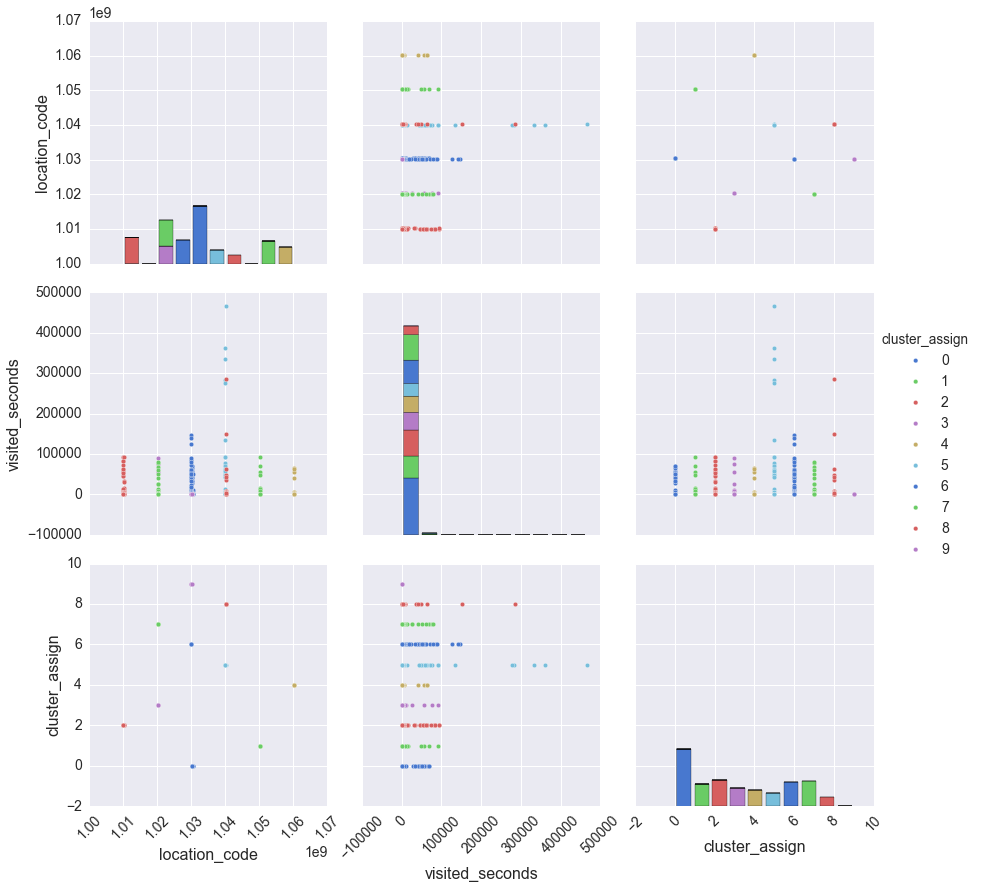

In [28]:
plot_data = df[columns_to_plot].apply(pd.to_numeric)   

#visualize the results for the first 10 clusters. This makes the plot easier to read. 
plot_data = plot_data[plot_data['cluster_assign'].isin(clusters_to_plot)]

#use a pair plot on all columns in the plot_data DataFrame
pp = seaborn.pairplot(plot_data, hue="cluster_assign", palette="muted", size=4)
seaborn.despine()

#rotate the x-axes to make them easier to read.
for ax in pp.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

## Resources 

Clustering:
+ [Agglomerative vs. divisive clustering algorithms](http://www.sthda.com/english/wiki/hierarchical-clustering-essentials-unsupervised-machine-learning#algorithm)
+ [Example of Agglomerative Clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering#Agglomerative_clustering_example)
+ [K-Means Visualization](http://stanford.edu/class/ee103/visualizations/kmeans/kmeans.html)
+ [K-Means : The Advantages of Careful Seeding](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf)
+ [Methods of determining the number of clusters](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set)
+ [K-Means parallel initialization method: K-Means||](http://theory.stanford.edu/~sergei/papers/vldb12-kmpar.pdf)


Spark: 
+ [Spark download link](http://spark.apache.org/downloads.html)
+ [Spark job execution architecture overview and explanation](http://spark.apache.org/docs/1.6.0/cluster-overview.html)
+ [Spark documentation](http://spark.apache.org/docs/1.6.0)
+ General resouce: Karau, H., Konwinski, A., Wendell, P., & Zaharia, M. (2015). Learning Spark: Lightening fast data analysis. Beijing: O'Reilly.
+ [Machine learning with Spark's MLLIB library](https://spark.apache.org/docs/1.6.0/mllib-guide.html)

Supplemental:
+ [File compression (tar/untar) tutorial by Indiana University](https://kb.iu.edu/d/acfi)